In [26]:
import numpy as np
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 

In [27]:
!pip install tensorflow

In [141]:
rutaDogsTrain = 'cat_dog_100/train/dog'
rutaDogsTest = 'cat_dog_100/test/dog'
rutaCatsTrain = 'cat_dog_100/train/cat'
rutaCatsTest = 'cat_dog_100/test/cat'

tamanoMax = 256
sizeVentana = 16
tamanoMax = int(tamanoMax/sizeVentana)*sizeVentana

In [29]:
from os import walk

dogTrain = []
dogTest = []
catTest = []
catTrain = []
for (dirpath, dirnames, filenames) in walk(rutaDogsTrain):
    dogTrain.extend(filenames)
    
for (dirpath, dirnames, filenames) in walk(rutaDogsTest):
    dogTest.extend(filenames)

for (dirpath, dirnames, filenames) in walk(rutaCatsTest):
    catTest.extend(filenames)

for (dirpath, dirnames, filenames) in walk(rutaCatsTrain):
    catTrain.extend(filenames)
    
print(f'{rutaDogsTrain}/{dogTrain[0]}')

cat_dog_100/train/dog/dog.10000.jpg


In [30]:
def recorta_imagen(imagen, n):
    """
    Esta función recibe una imagen y un tamaño n y recorta la imagen de tal manera que el número final de filas/columnas 
    sea múltiplo de n. La funció debe recortar las filas de la derecha/abajo.
    """
    size = np.min([int(imagen.shape[0]/n)*n, int(imagen.shape[1]/n)*n])
    return imagen[:size, :size]

def resize_image(imagen, sizeVentana, tamanoMax, recorta=False):
    if(recorta): imagen = recorta_imagen(imagen, sizeVentana)
    imagen2 = cv2.resize(imagen, [tamanoMax,tamanoMax])
    return imagen2

In [62]:
def esUniforme(binario):
    return np.sum(np.abs(np.diff(binario))) < 3

In [32]:
def ventana_a_decimal(ventana_binario):
    binario = np.array([ventana_binario[0,0], ventana_binario[0,1], ventana_binario[0,2], ventana_binario[1,2], ventana_binario[2,2], ventana_binario[2,1], ventana_binario[2,0], ventana_binario[1,0]])
#     anterior = binario[0]
#     cont = 0
#     for i in range(1, binario.shape[0]):
#         if binario[i] == anterior:
#             cont+=1
#         else:
#             cont = 0
#         anterior = binario[i]
#         if cont == 2:
#             binario = 0
#             break
    return np.sum(binario * np.array([128, 64, 32, 16, 8, 4, 2, 1]))

In [33]:
def transforma_bloque(celda):
    celda_ampliada = cv2.copyMakeBorder(celda, 1, 1, 1, 1, cv2.BORDER_REPLICATE)
    celda2 = np.empty(celda.shape)
    for i in range(1, celda.shape[0]+1):
        for j in range(1, celda.shape[1]+1):
            ventana = celda_ampliada[i-1:i+2, j-1:j+2]
            ventana2 = np.zeros(ventana.shape)
            pixel_central = ventana[1,1]
            ventana2[ventana>pixel_central] = 1
            celda2[i-1,j-1] = ventana_a_decimal(ventana2)
    return celda2

In [34]:
def transforma_imagen(imagen, sizeVentana, tamanoMax):
    imagen = resize_image(imagen, sizeVentana, tamanoMax, False)
    caracteristicas = []
    a = int(imagen.shape[0]/sizeVentana)
    for i in range(a):
        for j in range(a):
            celda = imagen[i*sizeVentana:(i+1)*sizeVentana,j*sizeVentana:(j+1)*sizeVentana]
            nueva_celda = transforma_bloque(celda)
            caracteristicas.append(cv2.calcHist([np.uint8(nueva_celda)], [0], None, [256], [0, 256]).ravel())
    return np.concatenate(caracteristicas)

<!-- a -->

In [71]:
def ventana_a_decimal2(ventana_binario):
    binario = np.array([ventana_binario[0,0], ventana_binario[0,1], ventana_binario[0,2], ventana_binario[1,2], ventana_binario[2,2], ventana_binario[2,1], ventana_binario[2,0], ventana_binario[1,0]])
    return np.sum(binario * np.array([128, 64, 32, 16, 8, 4, 2, 1]))

In [72]:
def transforma_bloque2(celda):
    celda_ampliada = cv2.copyMakeBorder(celda, 1, 1, 1, 1, cv2.BORDER_REPLICATE)
    lista = []
    for i in range(1, celda.shape[0]+1):
        for j in range(1, celda.shape[1]+1):
            ventana = celda_ampliada[i-1:i+2, j-1:j+2]
            ventana2 = np.zeros(ventana.shape)
            pixel_central = ventana[1,1]
            ventana2[ventana>pixel_central] = 1
            lista.append(ventana_a_decimal2(ventana2))
    return lista

In [94]:
def uniformar(hist):
    hist_uniforme = hist[[0, 1, 2, 3, 4, 6, 7, 8, 12, 14, 15, 16, 24, 28, 30, 31, 32, 48, 56, 60, 62, 63, 64, 96, 112, 120, 124, 126, 127, 128, 129, 131, 135, 143, 159, 191, 192, 193, 195, 199, 207, 223, 224, 225, 227, 231, 239, 240, 241, 243, 247, 248, 249, 251, 252, 253, 254, 255]]  
    return np.hstack([hist_uniforme, np.sum(histograma)-np.sum(hist_uniforme)])

def transforma_imagen2(imagen, sizeVentana, tamanoMax):
    imagen = resize_image(imagen, sizeVentana, tamanoMax, False)
    caracteristicas = []
    a = int(imagen.shape[0]/sizeVentana)
    for i in range(a):
        for j in range(a):
            celda = imagen[i*sizeVentana:(i+1)*sizeVentana,j*sizeVentana:(j+1)*sizeVentana]
            nueva_celda = transforma_bloque2(celda)
            histograma = cv2.calcHist([np.uint8(nueva_celda)], [0], None, [256], [0, 256]).ravel()
            caracteristicas.append(uniformar(histograma))
    return np.concatenate(caracteristicas)

In [83]:
n = 2
imagen = cv2.imread(f'{rutaDogsTrain}/{dogTrain[n]}')
caracteristicasR = transforma_imagen(imagen[:,:, 0], sizeVentana, tamanoMax)
caracteristicasG = transforma_imagen(imagen[:,:, 1], sizeVentana, tamanoMax)
caracteristicasB = transforma_imagen(imagen[:,:, 2], sizeVentana, tamanoMax)
caracteristicas = np.concatenate((caracteristicasR, caracteristicasG, caracteristicasB))
print(caracteristicas.shape)

(49152,)


In [82]:
imagen = cv2.imread(f'{rutaDogsTrain}/{dogTrain[n]}')
imagen[:,:, 1].shape

(375, 499)

In [ ]:
X = []
for i in tqdm(range(len(dogTrain)), desc = "Perros", colour = '#FF88F8'):
    imagen = cv2.imread(f'{rutaDogsTrain}/{dogTrain[i]}', 0)
    caracteristicas = transforma_imagen2(imagen, sizeVentana, tamanoMax)
#     caracteristicasR = transforma_imagen(imagen[:,:, 0], sizeVentana, tamanoMax)
#     caracteristicasG = transforma_imagen(imagen[:,:, 1], sizeVentana, tamanoMax)
#     caracteristicasB = transforma_imagen(imagen[:,:, 2], sizeVentana, tamanoMax)
#     caracteristicas = np.vstack((caracteristicasR, caracteristicasG, caracteristicasB))
    X.append(caracteristicas)

for i in tqdm(range(len(catTrain)), desc = "Gatos", colour = '#88FFDD'):
    imagen = cv2.imread(f'{rutaCatsTrain}/{catTrain[i]}', 0)
    caracteristicas = transforma_imagen2(imagen, sizeVentana, tamanoMax)
#     caracteristicasR = transforma_imagen(imagen[:,:, 0], sizeVentana, tamanoMax)
#     caracteristicasG = transforma_imagen(imagen[:,:, 1], sizeVentana, tamanoMax)
#     caracteristicasB = transforma_imagen(imagen[:,:, 2], sizeVentana, tamanoMax)
#     caracteristicas = np.vstack((caracteristicasR, caracteristicasG, caracteristicasB))
    X.append(caracteristicas)
    
X = np.array(X)
y = np.hstack((np.ones(len(dogTrain)), np.zeros(len(catTrain)))).reshape(-1, 1)


Gatos:  46%|████▌     | 46/100 [01:07<01:17,  1.44s/it]

In [ ]:
Xtest = []
for i in tqdm(range(len(dogTest)), desc = "Perros Test", colour = '#FF88BB'):
    imagen = cv2.imread(f'{rutaDogsTest}/{dogTest[i]}', 0)
    caracteristicas = transforma_imagen2(imagen, sizeVentana, tamanoMax)
#     caracteristicasR = transforma_imagen(imagen[:,:, 0], sizeVentana, tamanoMax)
#     caracteristicasG = transforma_imagen(imagen[:,:, 1], sizeVentana, tamanoMax)
#     caracteristicasB = transforma_imagen(imagen[:,:, 2], sizeVentana, tamanoMax)
#     caracteristicas = np.vstack((caracteristicasR, caracteristicasG, caracteristicasB))
    Xtest.append(caracteristicas)

for i in tqdm(range(len(catTest)), desc = "Gatos Test", colour = '#88FFE0'):
    imagen = cv2.imread(f'{rutaCatsTest}/{catTest[i]}', 0)
    caracteristicas = transforma_imagen2(imagen, sizeVentana, tamanoMax)
#     caracteristicasR = transforma_imagen(imagen[:,:, 0], sizeVentana, tamanoMax)
#     caracteristicasG = transforma_imagen(imagen[:,:, 1], sizeVentana, tamanoMax)
#     caracteristicasB = transforma_imagen(imagen[:,:, 2], sizeVentana, tamanoMax)
#     caracteristicas = np.vstack((caracteristicasR, caracteristicasG, caracteristicasB))
    Xtest.append(caracteristicas)
    
Xtest = np.array(Xtest)
ytest = np.hstack((np.ones(len(dogTest)), np.zeros(len(catTest)))).reshape(-1, 1)

In [98]:
Xtrain, Xval, ytrain, yval = train_test_split(X, y, test_size = 0.15, random_state = 42)
print(Xtrain.shape)

(170, 3776)


In [126]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D, LSTM, TimeDistributed, GRU, SimpleRNN
import tensorflow.keras as keras

#Para ver si detecta la GPU (si no, hacer "conda install -c conda-forge cudnn" o algo así)
print(tf.config.list_physical_devices())
print("Número de GPUs disponibles: ", len(tf.config.experimental.list_physical_devices('GPU')))

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Número de GPUs disponibles:  1


In [128]:
model = Sequential([
#     Conv1D(64, 3, input_shape = (3, 3776)),
#     MaxPooling1D(1),
#     GRU(64, kernel_regularizer = 'l2', dropout = 0.25),
    Dense(64, input_shape = (3776,)),
    Dense(1, activation = 'sigmoid')
])
model.summary()
model.compile(optimizer = keras.optimizers.Adamax(), loss = keras.losses.binary_crossentropy, metrics = ['acc'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 64)                241728    
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 241,793
Trainable params: 241,793
Non-trainable params: 0
_________________________________________________________________


In [137]:
historico = model.fit(
    Xtrain, 
    ytrain, 
    batch_size = 1000, 
    epochs = 32,
    validation_data= (Xval, yval)
)

Epoch 1/32
1/1 [==============================] - 0s 129ms/step - loss: 0.0021 - acc: 1.0000 - val_loss: 5.7271 - val_acc: 0.6000
Epoch 2/32
1/1 [==============================] - 0s 65ms/step - loss: 6.4724e-04 - acc: 1.0000 - val_loss: 5.7908 - val_acc: 0.5667
Epoch 3/32
1/1 [==============================] - 0s 77ms/step - loss: 2.2472e-04 - acc: 1.0000 - val_loss: 5.8549 - val_acc: 0.5667
Epoch 4/32
1/1 [==============================] - 0s 80ms/step - loss: 1.2334e-04 - acc: 1.0000 - val_loss: 5.9171 - val_acc: 0.5667
Epoch 5/32
1/1 [==============================] - 0s 75ms/step - loss: 1.2966e-04 - acc: 1.0000 - val_loss: 5.9761 - val_acc: 0.5667
Epoch 6/32
1/1 [==============================] - 0s 70ms/step - loss: 1.9021e-04 - acc: 1.0000 - val_loss: 6.0311 - val_acc: 0.5667
Epoch 7/32
1/1 [==============================] - 0s 120ms/step - loss: 2.9508e-04 - acc: 1.0000 - val_loss: 6.0818 - val_acc: 0.5667
Epoch 8/32
1/1 [==============================] - 0s 106ms/step - loss:

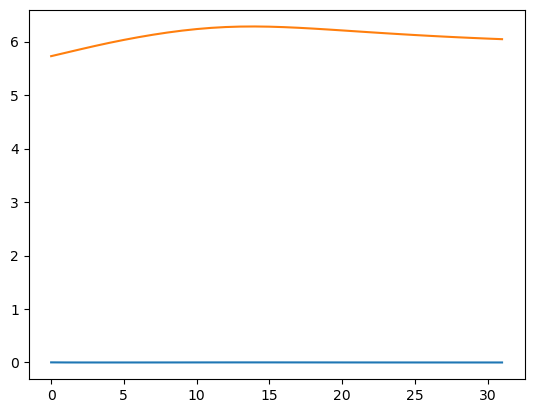

In [138]:
historial = historico.history
plt.plot(historial['loss'])
plt.plot(historial['val_loss'])

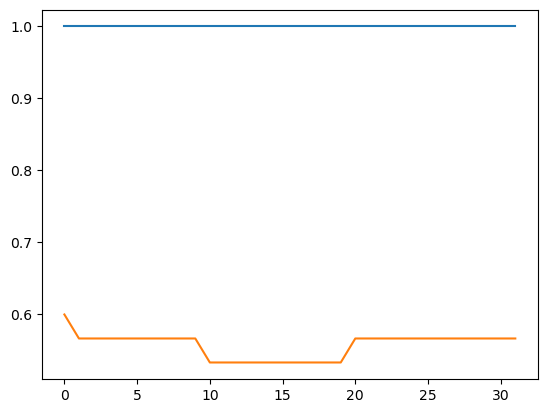

In [139]:
plt.plot(historial['acc'])
plt.plot(historial['val_acc'])

In [140]:
prediccion = model.predict(Xtest)
aciertos = np.sum(np.round(prediccion) == ytest)
print(f'{aciertos/ytest.shape[0]*100 }%')

2/2 [==============================] - 0s 7ms/step
77.5%


In [136]:
model.save('RGB_sin_modconv.h5')

In [99]:
# Importamos las SVMs
from sklearn import svm
# Creamos un clasificador SVM usando svm.SVC con kernel='linear', C=1.0 y máximo número de iteraciones = 1000
svc = svm.SVC(kernel = 'linear', C = 1.0, max_iter = 10000)
svc

SVC(kernel='linear', max_iter=10000)

In [124]:
# Importamos las SVMs
from sklearn import svm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
# Creamos un clasificador SVM usando svm.SVC con kernel='linear', C=1.0 y máximo número de iteraciones = 1000
clf = make_pipeline(StandardScaler(),  svm.SVC(C = 2))

# Entrenamos el modelo
clf.fit(X, y.ravel())
# Obtenemos la precisión
accTrain = clf.score(X, y)
print("Precisión en train: {}%".format(accTrain*100))

print(f"Predicción en test: {clf.score(Xtest, ytest)*100}%")

Precisión en train: 100.0%
Predicción en test: 92.5%
